<a href="https://colab.research.google.com/github/shehadeh7/APS360-Project/blob/main/working_model_with_dataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pydub
! pip install noisereduce
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
# Download dataset from Kaggle (direct link: https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en)
!kaggle datasets download dmitrybabko/speech-emotion-recognition-en

 99% 981M/987M [00:10<00:00, 93.3MB/s]
100% 987M/987M [00:10<00:00, 97.1MB/s]


In [3]:
!mkdir ./data

In [4]:
%%capture
!unzip speech-emotion-recognition-en.zip -d ./data

In [5]:
import numpy as np
import os
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [6]:
emotions = {
  'happy': 0, 
  'sad': 1, 
  'angry': 2, 
  'disgust': 3, 
  'fear': 4, 
  'neutral': 5
}

ravdess_emotions = {
    '01': emotions['neutral'],
    '03': emotions['happy'],
    '04': emotions['sad'],
    '05': emotions['angry'],
    '06': emotions['fear'],
    '07': emotions['disgust'],
}

crema_emotions = {
  'SAD': emotions['sad'], 
  'ANG': emotions['angry'], 
  'DIS': emotions['disgust'],
  'FEA': emotions['fear'], 
  'HAP': emotions['happy'], 
  'NEU': emotions['neutral']
}

savee_emotions = {
    'a': emotions['angry'],
    'd': emotions['disgust'],
    'f': emotions['fear'],
    'h': emotions['happy'],
    'n': emotions['neutral']
}

processed_data = []

data_path = "/content/data"
for root, dirs, files in os.walk(data_path):
  for file in files:
    file_path = os.path.join(root, file)

    dataset = file_path.split('/')[3]
    if dataset == 'Ravdess':
      emotion_label = ravdess_emotions.get(file.split('-')[2], None)
    elif dataset == 'Crema':
      emotion_label = crema_emotions.get(file.split('_')[2], None)
    elif dataset == 'Tess':
      emotion_label = emotions.get(file.split('_')[2].split('.')[0], None)
    else:
      emotion_code = file.split('_')[1][:2]
      if (emotion_code == 'sa'):
        emotion_label = emotions['sad']
      else:
        emotion_label = savee_emotions.get(emotion_code[0], None)

    if (emotion_label != None):
      processed_data.append([file_path, dataset, emotion_label])

In [7]:
import librosa


from pydub import AudioSegment, effects
import noisereduce as nr

frame_length = 2048
hop_length = 512
total_length = 180000 # verify this value?

def extract_feature(file_name): 

    y, sample_rate = librosa.load(file_name, sr=None)

    # Don't process corrupted audio signals
    if not np.any(y):
        return None

    rawsound = AudioSegment.from_file(file_name) 
    # Normalize the audio to +5.0 dBFS.
    normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transform the normalized audio to np.array of samples.
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    # Pad for duration equalization.
    padded_x = librosa.util.fix_length(xt, size=total_length)
    # Noise reduction.
    final_x = nr.reduce_noise(y=padded_x, sr=sample_rate)
    
    # Features extraction   
    # stft = np.abs(librosa.stft(final_x))
    mfccs = librosa.feature.mfcc(y=final_x, sr=sample_rate, n_mfcc=15)
    # print(mfccs.shape)
    # chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    # print(chroma.shape)
    # mel = librosa.feature.melspectrogram(final_x, sr=sample_rate)
    # print(mel.shape)
    zcr = librosa.feature.zero_crossing_rate(final_x)
    # print(zcr.shape)
    return mfccs,zcr

In [9]:
# Obtain features from each wav file
labels = []
features = []

mfccs = []
zcr = []
i = 0 # partially save results?
mylists = [mfccs, zcr]
for data in processed_data:
    i += 1
    # if i<=4000:
    #     continue    
    result = extract_feature(data[0])
    if result is not None:
        labels.append(data[2])
        for x, lst in zip(result, mylists):
            lst.append(x)
    if i%100 == 0:
        print(i)

8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300


In [10]:
# Change feature lists to np array of size timestamp x features
a_mfccs = np.asarray(mfccs).astype('float32')
a_mfccs = np.swapaxes(a_mfccs, 1, 2)
a_zcr = np.asarray(zcr).astype('float32')
a_zcr = np.swapaxes(a_zcr, 1, 2)

print('MFCCS shape:', a_mfccs.shape)

MFCCS shape: (11317, 352, 15)


In [11]:
# Create np arrays for data and labels
X = np.concatenate((a_mfccs, a_zcr), axis=2)
Y = np.array(labels)

In [12]:
# shuffle X and Y same way
# random_state to seed the shuffle
X, Y = shuffle(X, Y, random_state=0)
print(X.shape)
print(Y.shape)

(11317, 352, 16)
(11317,)


In [13]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(criterion='entropy')

training_split = 0.8 # use 80% of data for training

#Train the model using the training sets y_pred=clf.predict(X_test)
# Flatten X to a 2d array for random forest
nsamples, nx, ny = X.shape
t_id = int(nsamples * training_split)
X_2d = X.reshape((nsamples,nx*ny))
clf.fit(X_2d[:t_id,:], Y[:t_id])

RandomForestClassifier(criterion='entropy')

In [14]:
# Perform prediction
y_pred=clf.predict(X_2d[t_id:,:])

In [15]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(Y[t_id:], y_pred)

print(cf_matrix)

[[210  28  47  28  31  39]
 [ 23 257  11  41  17  29]
 [ 55   7 277  26  11  24]
 [ 41  65  33 189  15  25]
 [ 53  84  45  40 134  29]
 [ 56  56  11  40  20 167]]


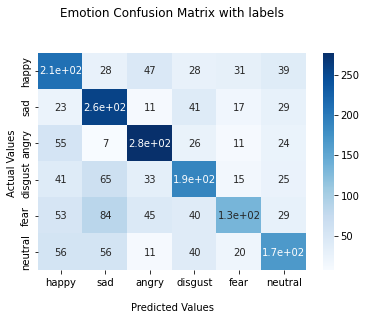

In [16]:
# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Emotion Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['happy', 'sad', 'angry', 'disgust', 'fear', 'neutral'])
ax.yaxis.set_ticklabels(['happy', 'sad', 'angry', 'disgust', 'fear', 'neutral'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [17]:
# Report useful metrics
ascore = sklearn.metrics.accuracy_score(Y[t_id:], y_pred)
rscore = sklearn.metrics.recall_score(Y[t_id:], y_pred, average='macro')
pscore = sklearn.metrics.precision_score(Y[t_id:], y_pred, average='macro')
fscore = sklearn.metrics.f1_score(Y[t_id:], y_pred, average='macro')
print('Accuracy:{}, Precision:{}, Recall:{}, F1:{}'.format(ascore, pscore, rscore, fscore))

Accuracy:0.5450530035335689, Precision:0.5483921584393526, Recall:0.5432464689455646, F1:0.5381147053357375


In [ ]:
# !pip install neural-structured-learning

In [18]:
#numpy save x and y
#zip together before saving?
# x_path = './x_data'
# y_path = './y_data'
# np.save(x_path, X)
# np.save(y_path, Y)

In [19]:
# ! zip processed_data.zip x_data.npy y_data.npy

  adding: x_data.npy (deflated 74%)
  adding: y_data.npy (deflated 92%)


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# Create a base model -- sequential, functional, or subclass.
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences = True, input_shape=(X_train.shape[1:3])),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

# # Wrap the model with adversarial regularization.
# adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
# adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)

rms = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

# Compile, train, and evaluate.
model.compile(optimizer=rms,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))
# model.evaluate(x_test, y_test)

Epoch 1/30
75/75 [==============================] - 31s 371ms/step - loss: 1.8023 - accuracy: 0.1658 - val_loss: 1.7932 - val_accuracy: 0.1813
Epoch 2/30
75/75 [==============================] - 26s 353ms/step - loss: 1.7930 - accuracy: 0.1567 - val_loss: 1.7913 - val_accuracy: 0.1762
Epoch 3/30
75/75 [==============================] - 26s 351ms/step - loss: 1.7898 - accuracy: 0.1658 - val_loss: 1.7886 - val_accuracy: 0.1863
Epoch 4/30
75/75 [==============================] - 27s 359ms/step - loss: 1.7855 - accuracy: 0.1742 - val_loss: 1.7879 - val_accuracy: 0.1775
Epoch 5/30
75/75 [==============================] - 26s 353ms/step - loss: 1.7805 - accuracy: 0.1925 - val_loss: 1.7843 - val_accuracy: 0.1900
Epoch 6/30
75/75 [==============================] - 26s 352ms/step - loss: 1.7765 - accuracy: 0.1942 - val_loss: 1.7816 - val_accuracy: 0.2013
Epoch 7/30
75/75 [==============================] - 26s 353ms/step - loss: 1.7722 - accuracy: 0.1983 - val_loss: 1.7791 - val_accuracy: 0.2125